# Problem Statement
Consider the samples from the World Wide Web that are provided in the data sets for Chapter 5 of LNR. Choose one of those samples and compute its degree distribution.  Use that to choose one of the evolving network models we studied in this module and proceed to fit that model to the sample data you chose.  

Now construct a subsample of no more than $N$ nodes, stipulating that two nodes in the subsample are connected if and only if the distance between them in the original sample was no more than $D$.  Perform the same analysis as above.  

What is the uncertainty of your model choice and parameter estimates?  How does the accuracy of your analysis improve as $N$ and $D$ increase?  How large do they need to be for your model choice and parameter estimates to be robust?


# Initialization and Setup

In [230]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import scipy.optimize
import scipy.stats
import random
import collections
from tqdm import tqdm
import time

In [109]:
# Global constants
N = 875713
K = 5105039
file_name = "./www/web-Google.net"

In [110]:
# Importing dataset as an edge list (note the dataset is directed and unweighted)
# Read data from `file_name` while calculating degrees
E = np.zeros((K,2))

with open(file_name, "r") as data_file:
    for it, line in enumerate(data_file.readlines()):
        tail, head = [int(k) for k in line.split()]
        E[it,0] = tail
        E[it,1] = head

# Relabel edges in storage from 0 to 875712, inclusive
_labels = dict(zip(np.sort(np.unique(E)), range(len(np.unique(E)))))
_relabel = np.vectorize(lambda index: _labels[index])
E = _relabel(E)

G = nx.DiGraph(tuple(map(tuple, E)))

In [111]:
# Calculate degrees of nodes in network
D_in = np.zeros(N)
D_out = np.zeros(N)

for row in E:
    D_out[row[0]] += 1
    D_in[row[1]] += 1

In [112]:
# Note <k^{in}> = <k^{out}> = k_avg.
k_avg = np.average(D_in)
k_avg

5.829580010802626

# Visualizing in- and out-degree distributions

In [288]:
k_min = 1 # ignore nodes with degree less than k_min

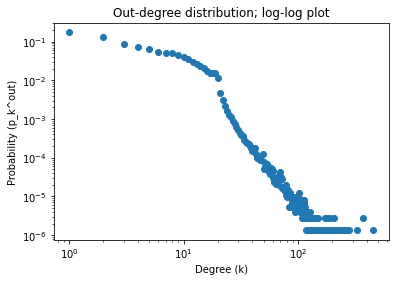

In [289]:
degrees_out, frequencies_out = np.unique(D_out[D_out >= k_min], return_counts=True)
probabilities_out = frequencies_out * 1/(len(D_out) - np.count_nonzero(D_out < k_min))

plt.title("Out-degree distribution; log-log plot")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (k)")
plt.ylabel("Probability (p_k^out)")
plt.scatter(degrees_out, probabilities_out)
plt.show()

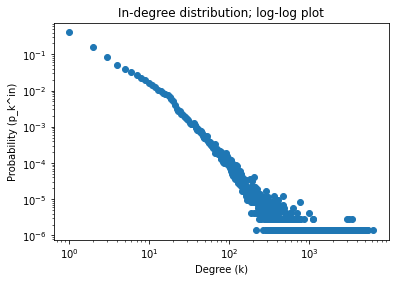

In [290]:
degrees_in, frequencies_in = np.unique(D_in[D_in >= k_min], return_counts=True)
probabilities_in = frequencies_in * 1/(len(D_in) - np.count_nonzero(D_in < k_min))

plt.title("In-degree distribution; log-log plot")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (k)")
plt.ylabel("Probability (p_k^in)")
plt.scatter(degrees_in, probabilities_in)
plt.show()

Clearly the data seems to behave as a power-law distribution $f(x)=cx^{-\gamma}$, so we now move to determine the values of these paramters by utilizing *cumulative distribution functions*. Note that the cumulative distribution function $P(k)$ of a power-law distribution $p(k)=ck^{-\gamma}$ is simply

$\displaystyle P(k)=c\int_k^{\infty} x^{-\gamma}\;dx=\frac{c}{\gamma-1}k^{-(\gamma-1)}$.

In [291]:
def pdf_to_cdf(pdf):
    return np.array([np.sum(pdf[k:]) for k in range(len(pdf))])

cumulative_probabilities_out = pdf_to_cdf(probabilities_out)
cumulative_probabilities_in = pdf_to_cdf(probabilities_in)

## Calculating $\gamma$ values
Through the code below we see that...
- **$\gamma^{in}=2.416$ and $\gamma^{out}=3.824$ for the Google dataset, $k_{min}=25$.**
- **$\gamma^{in}=2.444$ and $\gamma^{out}=2.696$ for the Notre Dame dataset.**

In [292]:
def power_law(x, gamma, c):
    return gamma * x + np.log(c) # Linear function when converted back to linear space becomes an exponential c * x^\gamma.

def power_law_fit(degrees_in, degrees_out, cumulative_probabilities_in, cumulative_probabilities_out):
    in_opt, in_cov = scipy.optimize.curve_fit(power_law, np.log(degrees_in), np.log(cumulative_probabilities_in))
    out_opt, out_cov = scipy.optimize.curve_fit(power_law, np.log(degrees_out), np.log(cumulative_probabilities_out))

    in_lin = scipy.stats.linregress(np.log(degrees_in), np.log(cumulative_probabilities_in))
    out_lin = scipy.stats.linregress(np.log(degrees_out), np.log(cumulative_probabilities_out))

    # We can recover coefficients:
    gamma_in = -(in_opt[0]-1)
    gamma_out = -(out_opt[0]-1)
    c_in = in_opt[1]*(-in_opt[0])
    c_out = out_opt[1]*(-out_opt[0])
    r_in = in_lin[2]
    r_out = out_lin[2]

    return gamma_in, gamma_out, c_in, c_out, r_in, r_out

gamma_in, gamma_out, c_in, c_out, r_in, r_out = power_law_fit(degrees_in, degrees_out, cumulative_probabilities_in, cumulative_probabilities_out)

print("IN gamma: {}, c: {}, r: {}".format(gamma_in, c_in, r_in))
print("OUT gamma: {}, c: {}, r: {}".format(gamma_out, c_out, r_out))

IN gamma: 2.4163259397377335, c: 4.769886512746517, r: -0.9908718765768825
OUT gamma: 3.694574744748463, c: 148.044309124785, r: -0.9857007606082703


In [306]:
# Manually set gamma based on predetermined values.
gamma_in = 2.4163
gamma_out = 3.824

## Plotting cumulative distributions with corresponding functions

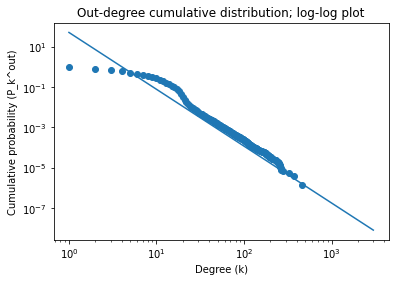

In [297]:
plt.title("Out-degree cumulative distribution; log-log plot")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (k)")
plt.ylabel("Cumulative probability (P_k^out)")
plt.scatter(degrees_out, cumulative_probabilities_out)
plt.plot(np.arange(1,3000,0.1), (c_out/(gamma_out-1))*np.arange(1,3000,0.1)**(-gamma_out+1))
plt.show()

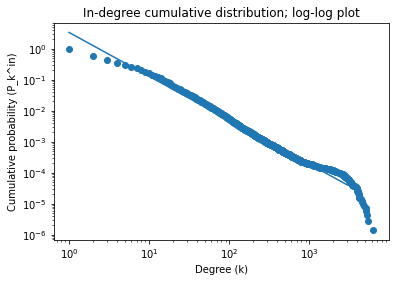

In [298]:
plt.title("In-degree cumulative distribution; log-log plot")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (k)")
plt.ylabel("Cumulative probability (P_k^in)")
plt.scatter(degrees_in, cumulative_probabilities_in)
plt.plot(np.arange(1,3000,0.1), (c_in/(gamma_in-1))*np.arange(1,3000,0.1)**(-gamma_in+1))
plt.show()

# Fitting the Web Graph (KRR) model

Note that in the KRR model, we find that by the rate equations, $\gamma^{in}=2+pa$ and $\gamma^{out}=1+q^{-1}+bpq^{-1}$, where $q=1-p$. We can determine $p=\langle k^{in}\rangle^{-1}=\langle k^{out}\rangle^-1$, and solve for $a$ and $b$ accordingly.

In [237]:
def KRR_model(T, p, a, b):
    KRR_D_out = np.zeros((100000)) # arbitrary large size
    KRR_D_in = np.zeros((100000)) # arbitrary large size

    def in_degree_offset(node):
        return KRR_D_in[node] + a

    def out_degree_offset(node):
        return KRR_D_out[node] + b

    N = 2 # initial number of nodes
    G = nx.DiGraph([(0,1)]) # Initialize KRR model at time 0
    KRR_D_out[0] = 1 # set first edge
    KRR_D_in[1] = 1 # set first edge

    # This is O(T^3).
    for time in tqdm(range(T)):
        if(random.random() <= p):
            offset_degrees = np.array([in_degree_offset(k) for k in range(N)])
            target = random.choices(list(range(len(offset_degrees))), weights=offset_degrees/np.sum(offset_degrees))[0]

            N += 1
            G.add_edge(N, target)
            KRR_D_out[N] += 1
            KRR_D_in[target] += 1
        else:
            offset_degrees = np.array([[in_degree_offset(i)*out_degree_offset(j) for i in range(N)] for j in range(N)]) # columns are in-degree, rows are out-degree
            offset_degrees = offset_degrees.flatten()
            target = random.choices(list(range(len(offset_degrees))), weights=offset_degrees/np.sum(offset_degrees))[0]
            G.add_edge(target // N, target % N)
            KRR_D_out[target // N] += 1
            KRR_D_in[target % N] += 1
    
    return G

In [238]:
T = 2000 # time
p = 1/k_avg # probability of creating new node
a = (gamma_in-2)/p # tuning constant
b = (gamma_out-1-(1/(1-p)))/(p*(1/(1-p))) # tuning constant
print("a: {}, b: {}".format(a,b))
time.sleep(0.5)

KRR_full = KRR_model(T, p, a, b)

a: 2.42700537627371, b: 7.184084314048141
100%|██████████| 2000/2000 [01:11<00:00, 27.98it/s]


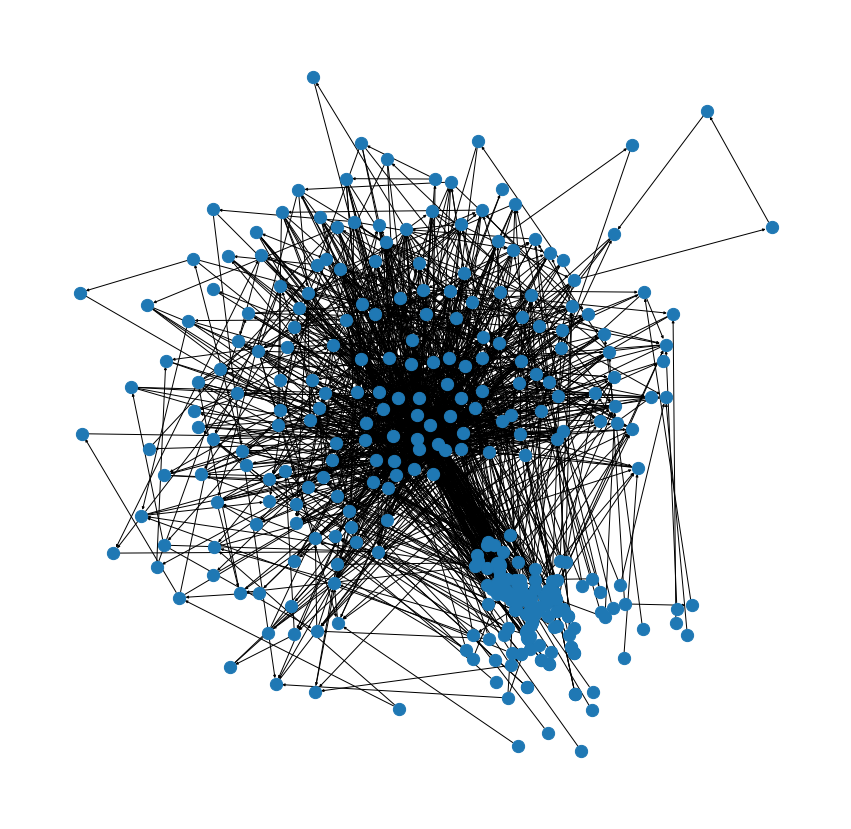

In [305]:
fig, ax = plt.subplots(figsize=(15,15))
nx.draw_kamada_kawai(KRR_full, ax=ax, arrowsize=5, node_size=150) # use Kamada-Kawai
plt.show()

In [299]:
# NetworkX degree histogram code adapted from https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree_histogram.html.

def degree_probabilities(G): # G is a directed graph
    in_degree_sequence = sorted([d for n, d in G.in_degree()])  # degree sequence
    in_degree_count = collections.Counter(in_degree_sequence)
    in_deg, in_count = zip(*in_degree_count.items())
    in_prob = np.array(in_count) * 1/len(G.nodes)

    out_degree_sequence = sorted([d for n, d in G.out_degree()])  # degree sequence
    out_degree_count = collections.Counter(out_degree_sequence)
    out_deg, out_count = zip(*out_degree_count.items())
    out_prob = np.array(out_count) * 1/len(G.nodes)

    cumulative_in_prob = np.array([np.sum(in_prob[k:]) for k in range(len(in_prob))])
    cumulative_out_prob = np.array([np.sum(out_prob[k:]) for k in range(len(out_prob))])

    return in_deg, in_prob, cumulative_in_prob, out_deg, out_prob, cumulative_out_prob

KRR_in_deg, KRR_cumulative_in_prob, KRR_out_deg, KRR_cumulative_out_prob = cumulative_degree_probabilities(KRR_full)

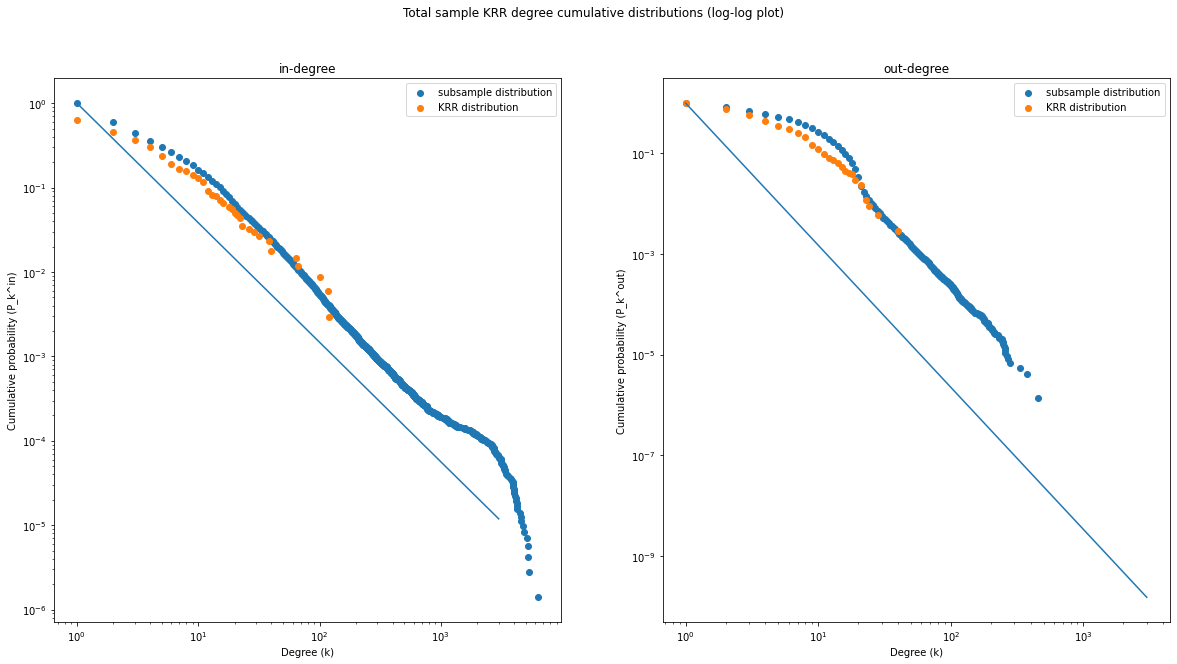

In [300]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

fig.suptitle("Total sample KRR degree cumulative distributions (log-log plot)")
ax1.set_title("in-degree")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Degree (k)")
ax1.set_ylabel("Cumulative probability (P_k^in)")
plt_subsample = ax1.scatter(degrees_in, cumulative_probabilities_in, label="subsample distribution")
plt_krr = ax1.scatter(KRR_in_deg, KRR_cumulative_in_prob, label="KRR distribution")
ax1.legend()
ax1.plot(np.arange(1,3000,0.1), np.arange(1,3000,0.1)**(-gamma_in+1))

ax2.set_title("out-degree")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Degree (k)")
ax2.set_ylabel("Cumulative probability (P_k^out)")
ax2.scatter(degrees_out, cumulative_probabilities_out, label="subsample distribution")
ax2.scatter(KRR_out_deg, KRR_cumulative_out_prob, label="KRR distribution")
ax2.legend()
ax2.plot(np.arange(1,3000,0.1), np.arange(1,3000,0.1)**(-gamma_out+1))

plt.show()

This shows that the KRR model seems to be working effectively, as its degree distributions match the exponent $\gamma$ of the original dataset.

# $(N,D)$ subsampling and the KRR model

Naive implementation of the max-distance condition in the problem. This runs too slowly to be practical.

```
def try_except(success, failure):
    try:
        return success()
    except:
        return failure()

for source in tqdm(sample): # O(N^2).
    for target in sample:
        distance_st = try_except(lambda: nx.shortest_path_length(G, source=source, target=target), lambda: np.inf)
        if(distance_st <= max_D and source != target):
            SG.add_edge(source, target)
```

In [125]:
def ND_subgraph(N_sample, D_max): # Creating sample subgraphs.
    sample = random.sample(list(range(N)), N_sample)
    SG = nx.DiGraph()
    SG.add_nodes_from(sample)

    SPL = {} # calculate shortest path lengths
    for i in tqdm(sample):
        SPL[i] = nx.shortest_path_length(G, source=i)

    for i in sample:
        for j in sample:
            if(j in SPL[i] and SPL[i][j] <= D_max):
                SG.add_edge(i,j)
    
    return SG, SPL

In [301]:
def graph_analysis(SG, T=1000):
    SG_deg_in, SG_p_in, SG_cp_in, SG_deg_out, SG_p_out, SG_cp_out = degree_probabilities(SG)
    SG_gamma_in, SG_gamma_out, SG_c_in, SG_c_out, SG_r_in, SG_r_out = power_law_fit(SG_deg_in, SG_deg_out, SG_cp_in, SG_cp_out)

    SG_T = T # time
    SG_p = 1/np.average([val for (node, val) in SG.degree()]) # probability of creating new node
    SG_a = (SG_gamma_in-2)/SG_p # tuning constant
    SG_b = (SG_gamma_out-1-(1/(1-SG_p)))/(SG_p*(1/(1-SG_p))) # tuning constant

    print("gamma_in: {}\ngamma_out: {}\n".format(SG_gamma_in, SG_gamma_out))
    print("r_in: {}\nr_out: {}\n".format(SG_r_in, SG_r_out))
    print("p: {}\na: {}\nb: {}".format(SG_p, SG_a, SG_b))
    time.sleep(0.5)

    SG_KRR = KRR_model(SG_T, SG_p, SG_a, SG_b)
    SG_KRR_deg_in, SG_KRR_p_in, SG_KRR_cp_in, SG_KRR_deg_out, SG_KRR_p_out, SG_KRR_cp_out = degree_probabilities(SG_KRR)

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))

    fig.suptitle("Subgraph KRR degree PDF and CDF over degree (log-log plot)")
    ax[0,0].set_title("in-degree PDF")
    ax[0,0].set_xscale("log")
    ax[0,0].set_yscale("log")
    ax[0,0].set_xlabel("Degree (k)")
    ax[0,0].set_ylabel("Probability (p_k^in)")
    ax[0,0].scatter(SG_deg_in, SG_p_in, label="subsample distribution")
    ax[0,0].scatter(SG_KRR_deg_in, SG_KRR_p_in, label="KRR distribution")
    ax[0,0].legend()
    ax[0,0].plot(np.arange(1,3000,0.1), SG_c_in*np.arange(1,3000,0.1)**(-SG_gamma_in))

    ax[0,1].set_title("out-degree PDF")
    ax[0,1].set_xscale("log")
    ax[0,1].set_yscale("log")
    ax[0,1].set_xlabel("Degree (k)")
    ax[0,1].set_ylabel("Probability (p_k^out)")
    ax[0,1].scatter(SG_deg_out, SG_p_out, label="subsample distribution")
    ax[0,1].scatter(SG_KRR_deg_out, SG_KRR_p_out, label="KRR distribution")
    ax[0,1].legend()
    ax[0,1].plot(np.arange(1,3000,0.1), SG_c_out*np.arange(1,3000,0.1)**(-SG_gamma_out))

    ax[1,0].set_title("in-degree CDF")
    ax[1,0].set_xscale("log")
    ax[1,0].set_yscale("log")
    ax[1,0].set_xlabel("Degree (k)")
    ax[1,0].set_ylabel("Cumulative probability (P_k^in)")
    ax[1,0].scatter(SG_deg_in, SG_cp_in, label="subsample distribution")
    ax[1,0].scatter(SG_KRR_deg_in, SG_KRR_cp_in, label="KRR distribution")
    ax[1,0].legend()
    ax[1,0].plot(np.arange(1,3000,0.1), np.arange(1,3000,0.1)**(-SG_gamma_in+1))

    ax[1,1].set_title("out-degree CDF")
    ax[1,1].set_xscale("log")
    ax[1,1].set_yscale("log")
    ax[1,1].set_xlabel("Degree (k)")
    ax[1,1].set_ylabel("Cumulative probability (P_k^out)")
    ax[1,1].scatter(SG_deg_out, SG_cp_out, label="subsample distribution")
    ax[1,1].scatter(SG_KRR_deg_out, SG_KRR_cp_out, label="KRR distribution")
    ax[1,1].legend()
    ax[1,1].plot(np.arange(1,3000,0.1), np.arange(1,3000,0.1)**(-SG_gamma_out+1))

    plt.show()

### $N=100, D=6$

100%|██████████| 100/100 [02:39<00:00,  1.60s/it]
gamma_in: 3.116653411790946
gamma_out: 3.1402575391780454

r_in: -0.9896278818986032
r_out: -0.9925786614821428

p: 0.31446540880503143
a: 3.5509578494952088
b: 1.4857614354081392
100%|██████████| 1000/1000 [00:23<00:00, 42.19it/s]


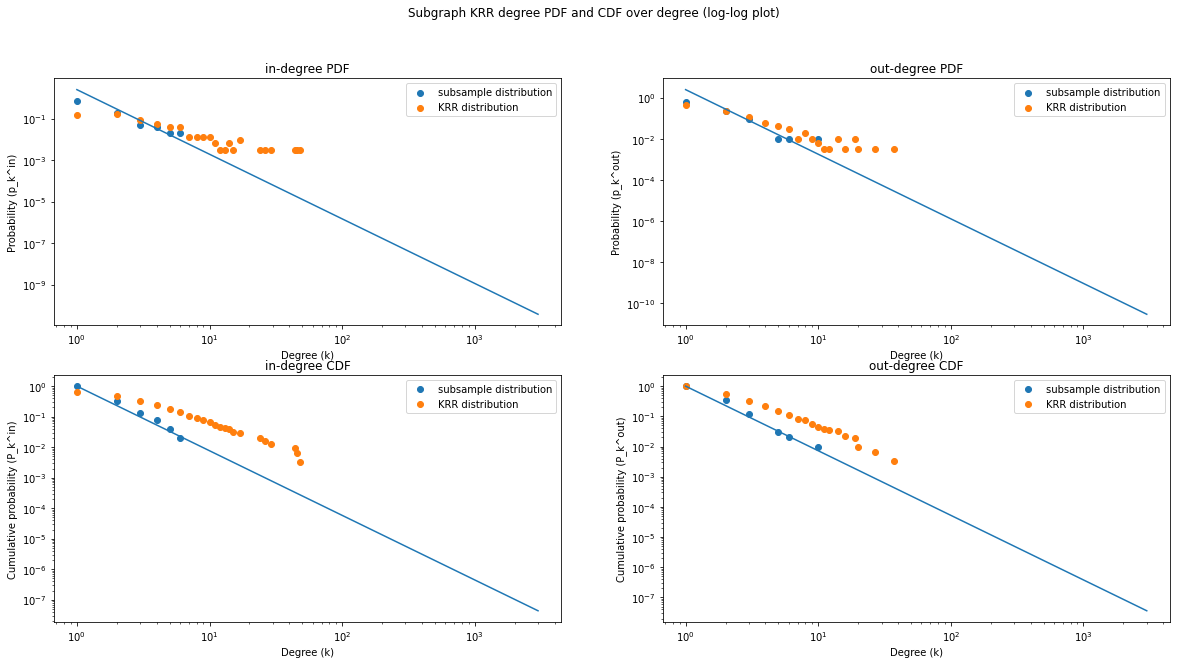

In [302]:
graph_analysis(ND_subgraph(100,6)[0])

### $N=500$, $D=6$

In [128]:
SG0, SG0_SPL = ND_subgraph(500,6)

100%|██████████| 500/500 [14:43<00:00,  1.77s/it]


gamma_in: 2.6145416683935325
gamma_out: 2.5121322571249194

r_in: -0.9577544410767966
r_out: -0.9663564634282268

p: 0.12671059300557527
a: 4.849962846961758
b: 2.5296155161049447
100%|██████████| 1000/1000 [00:04<00:00, 210.15it/s]


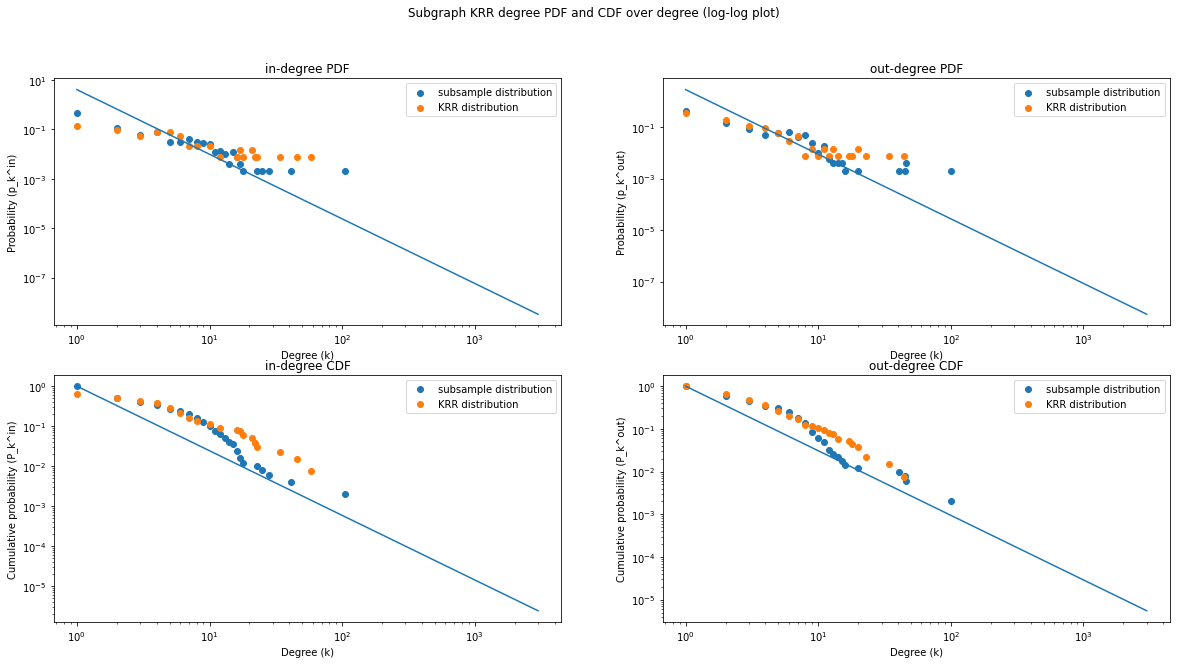

In [303]:
graph_analysis(SG0)

### $N=1000$, $D=6$

In [130]:
SG1, SG1_SPL = ND_subgraph(1000,6)

100%|██████████| 1000/1000 [40:36<00:00,  2.44s/it]


gamma_in: 2.4446688477240177
gamma_out: 2.5229745507974224

r_in: -0.9743523198079695
r_out: -0.9636467325276835

p: 0.07805182641273806
a: 5.697097277040115
b: 5.177375394019152
100%|██████████| 1000/1000 [00:02<00:00, 439.08it/s]


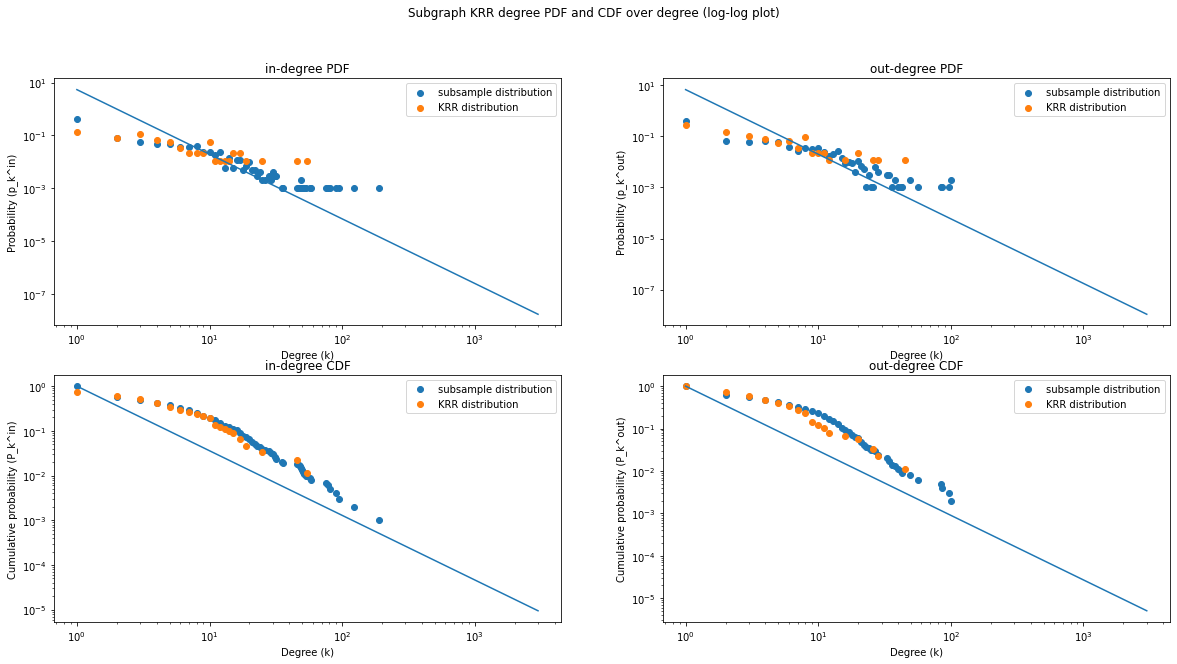

In [304]:
graph_analysis(SG1)

# Sampling community structure (Maiya '10)
This is an algorithm for creating a representative sample of a graph. The algorithmic procedure is as follows:

1. Select a random vertex $u\in G$, and set $S=\{u\}$.
2. Repeat the following $k$ times:

    a. Choose a vertex $v\in N(S)$ that maximizes $|N(\{v\})-\{N(S)\cup S\}|$, where $N(S)=\{w\in G\mid\exists u\in S\;s.t. (u,w)\in E\}$ are the neighbors of $v$.
    
    b. Add $v$ to $S$, i.e., $S=S\cup \{v\}$.

In [220]:
def SCS(G, k):
    v = random.choice(list(G.nodes))
    S = set([v])
    N_S = set(G.neighbors(v))
    union = S | N_S
    node_order = [v]
    
    for i in tqdm(range(k-1)):
        to_add = None
        max_expansion = -1
        for elem in N_S:
            current_expansion = len(set(G.neighbors(elem)) - union)
            if(current_expansion > max_expansion):
                to_add = elem
                max_expansion = current_expansion
        
        S.add(to_add)
        N_S.update(set(G.neighbors(to_add)))
        N_S.difference_update(set([to_add]))
        union.update(set(G.neighbors(to_add)))
        node_order.append(to_add)
    
    SG = nx.DiGraph(G.subgraph(S).edges)
    SG.add_edge(node_order[-1], node_order[-2]) # prevent errors with zero out-degree.
    return SG

In [221]:
SCS1 = SCS(G, 1000)

100%|██████████| 999/999 [00:51<00:00, 19.32it/s]


gamma_in: 2.939223579286346
gamma_out: 2.939223579286346

p: 0.1385809312638581
a: 6.777437348130274
b: 4.838213768843928
100%|██████████| 1000/1000 [00:06<00:00, 152.94it/s]


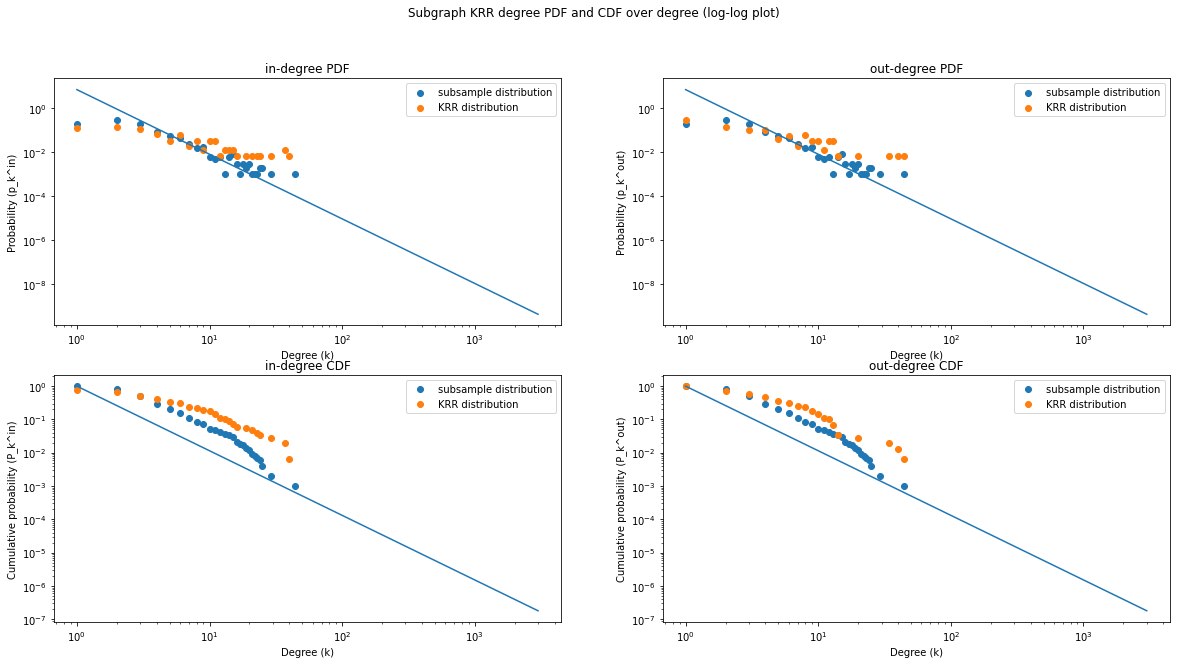

In [226]:
graph_analysis(SCS1.to_undirected().to_directed())